In [9]:
!pip install keras-rectified-adam

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.17.0-cp36-none-any.whl size=14781 sha256=7c75e59daf7c12f3fbd987a56cc484dfe8b4206e514afeb4aea9733c47a0737d
  Stored in directory: /root/.cache/pip/wheels/7b/01/27/3a934e1a5644f5b93c720422a6ef97034ea78a21ba71cfb549
Successfully built keras-rectified-adam


# static

In [1]:
PATH_TRAIN = '/content/drive/MyDrive/SIGNATE/DATASET/train.csv'
PATH_TEST = '/content/drive/MyDrive/SIGNATE/DATASET/test.csv'
PATH_SAMPLE_SUBMISSION = '/content/drive/MyDrive/SIGNATE/DATASET/sample_submit.csv'

# function

In [2]:
def remove_no_needed_columns(df_train, df_test):
  df_train = df_train.drop('id', axis=1)
  df_train = df_train.drop('html_content', axis=1)
  df_train = df_train.drop('state', axis=1)

  df_test = df_test.drop('id', axis=1)
  df_test = df_test.drop('html_content', axis=1)

  return df_train, df_test

In [3]:
import numpy as np

def preprocessing_dataframe(df):
  ### goal ###
  df['goal'] = df['goal'].replace('100000+', '100000-100000')
  df = pd.concat([df, df['goal'].str.split('-', expand=True)], axis=1)
  df.rename(columns={0: 'min', 1: 'max'}, inplace=True)
  df['min'] = df['min'].astype(int)
  df['max'] = df['max'].astype(int)
  df = pd.concat([df, df[['min', 'max']].mean(axis=1)], axis=1)
  df.rename(columns={0: 'mean'}, inplace=True)
  df = pd.concat([df, df[['min', 'max', 'mean']].quantile(q=0.25, axis=1), df[['min', 'max', 'mean']].quantile(q=0.75, axis=1)], axis=1)
  df.rename(columns={0.25: '0.25', 0.75: '0.75'}, inplace=True)
  df = pd.concat([df, pd.DataFrame(pd.qcut(df['mean'], 3, labels=['mean_Q1', 'mean_Q2', 'mean_Q3']).values, columns=['mean_bin_3'])], axis=1)
  df = pd.concat([df, pd.DataFrame(pd.cut(df['max'], bins=[-1, 19999, 49999, 79999, 99999, np.inf], labels=['bins_g1', 'bins_g2', 'bins_g3', 'bins_g4', 'bins_g5']).values, columns=['bins_goal'])], axis=1)
 
  ### duration ###
  df = pd.concat([df, pd.DataFrame(pd.cut(df['duration'], bins=[-1, 30, 45, 60, 100], labels=['bins_d1', 'bins_d2', 'bins_d3', 'bins_d4']).values, columns=['bins_duration'])], axis=1)

  ### goal x duration ###
  df['ratio_goalMax_duration'] = df['max'] / (df['duration'] + 1)
  df['ratio_goalMin_duration'] = df['min'] / (df['duration'] + 1)
  df['ratio_goalMean_duration'] = df['mean'] / (df['duration'] + 1)
  df['prod_goalMax_duration'] = df['max'] * (df['duration'])
  df['prod_goalMin_duration'] = df['min'] * (df['duration'])
  df['prod_goalMean_duration'] = df['mean'] * (df['duration'])

  ### category x category ###
  df['category3'] = df['category1'].astype(str) + df['category2'].astype(str)
  df['country+category1'] = df['country'].astype(str) + df['category1'].astype(str)
  df['country+category2'] = df['country'].astype(str) + df['category2'].astype(str)
  df['country+category3'] = df['country'].astype(str) + df['category3'].astype(str)
  df['bins_DurationGoal'] = df['bins_duration'].astype(str) + df['bins_goal'].astype(str)

  return df

In [11]:
import keras.backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())

    return f1_val

# import data

In [4]:
import pandas as pd

df_train = pd.read_csv(PATH_TRAIN)
df_test = pd.read_csv(PATH_TEST)

Y_train = df_train['state'].astype(int).values

train_html = df_train['html_content'].values
test_html = df_test['html_content'].values
data_html = pd.concat([df_train['html_content'], df_test['html_content']], axis=0)

print('df_train: {0}'.format(df_train.shape))
print('df_test: {0}'.format(df_test.shape))
print('Y_train: {0}'.format(Y_train.shape))
print('train_html: {0}'.format(train_html.shape))
print('test_html: {0}'.format(test_html.shape))

df_train: (10545, 8)
df_test: (10544, 7)
Y_train: (10545,)
train_html: (10545,)
test_html: (10544,)


# preprocessing

## for train_data

In [5]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import numpy as np

def one_hot_encoding(df_train, df_test):

  df = pd.concat([df_train, df_test], axis=0)

  train_data = np.empty((len(df_train), 0), int)
  test_data = np.empty((len(df_test), 0), int)

  for tp, column in zip(df.dtypes, df.columns):
    print(column)
    if tp == 'object' or 'category':
      one_hot_encoder = OneHotEncoder(sparse=False)
      one_hot_encoder.fit(df[column].astype('str').values.reshape(-1, 1))
      train_temp = one_hot_encoder.transform(df_train[column].astype('str').values.reshape(-1, 1))
      test_temp = one_hot_encoder.transform(df_test[column].astype('str').values.reshape(-1, 1))
      train_data = np.concatenate([train_data, train_temp], axis=1)
      test_data = np.concatenate([test_data, test_temp], axis=1)
    else:
      mm = preprocessing.MinMaxScaler()
      mm.fit(df[column])
      train_temp = mm.transform(df_train[column]) 
      test_temp = mm.transform(df_test[column])
      train_data = np.concatenate([train_data, train_temp], axis=1)
      test_data = np.concatenate([test_data, test_temp], axis=1)
    print(train_temp.shape)

  return train_data, test_data

In [6]:
df_train, df_test = remove_no_needed_columns(df_train, df_test)

df_train = preprocessing_dataframe(df_train)
df_test = preprocessing_dataframe(df_test)

print('df_train: {0}'.format(df_train.shape))
print('df_test: {0}'.format(df_test.shape))

train_data, test_data = one_hot_encoding(df_train, df_test)

print('train_data shape: {0}'.format(train_data.shape))
print('test_data shape: {0}'.format(test_data.shape))

df_train: (10545, 24)
df_test: (10544, 24)
goal
(10545, 101)
country
(10545, 22)
duration
(10545, 76)
category1
(10545, 15)
category2
(10545, 145)
min
(10545, 101)
max
(10545, 100)
mean
(10545, 101)
0.25
(10545, 101)
0.75
(10545, 101)
mean_bin_3
(10545, 3)
bins_goal
(10545, 5)
bins_duration
(10545, 4)
ratio_goalMax_duration
(10545, 1146)
ratio_goalMin_duration
(10545, 1689)
ratio_goalMean_duration
(10545, 1689)
prod_goalMax_duration
(10545, 875)
prod_goalMin_duration
(10545, 1689)
prod_goalMean_duration
(10545, 1689)
category3
(10545, 155)
country+category1
(10545, 300)
country+category2
(10545, 1586)
country+category3
(10545, 1643)
bins_DurationGoal
(10545, 18)
train_data shape: (10545, 13354)
test_data shape: (10544, 13354)


## for train_html

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tokenizer = TfidfVectorizer(max_features=200)

tfidf = tokenizer.fit(data_html)

train_html = tfidf.transform(train_html)
test_html = tfidf.transform(test_html)

train_html = train_html.toarray()
test_html = test_html.toarray()

print('train_html: {0}'.format(train_html.shape))
print('test_html: {0}'.format(test_html.shape))
print('train_html type: {0}'.format(type(train_html)))
print('test_html type: {0}'.format(type(test_html)))

train_html: (10545, 200)
test_html: (10544, 200)
train_html type: <class 'numpy.ndarray'>
test_html type: <class 'numpy.ndarray'>


In [19]:
from keras.models import Model
from keras import Input
from keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, concatenate
from keras.optimizers import Adagrad, RMSprop, SGD, Adam, Adadelta
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras_radam import RAdam
import tensorflow_addons as tfa

dropout_rate = 0.2

tfidf_input = Input(shape=(200,))
x = Dropout(dropout_rate)(tfidf_input)
x = Dense(100, activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(dropout_rate)(x)
tfidf_model = Dense(50, activation='relu')(x)

nn_input = Input(shape=(13354,))
y = Dropout(dropout_rate)(nn_input)
y = Dense(1000, activation='relu')(y)
y = Dropout(dropout_rate)(y)
y = Dense(1000, activation='relu')(y)
y = Dropout(dropout_rate)(y)
y = Dense(500, activation='relu')(y)
y = Dropout(dropout_rate)(y)
nn_model = Dense(250, activation='relu')(y)

concatenated = concatenate([tfidf_model, nn_model], axis=-1)

z = Dense(100, activation='relu')(concatenated)
z = Dropout(dropout_rate)(z)
z = Dense(32, activation='relu')(z)
z = Dropout(dropout_rate)(z)
z = Dense(32, activation='relu')(z)
z = Dropout(dropout_rate)(z)
output = Dense(1, activation='sigmoid')(z)

model = Model([tfidf_input, nn_input], output)

model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=[binary_accuracy, f1_score])

In [20]:
EPOCHS = 10
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.1

history = model.fit([train_html, train_data], Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Epoch 1/10
297/297 [==============================] - 25s 80ms/step - loss: 0.6193 - binary_accuracy: 0.6402 - f1_score: 0.6203 - val_loss: 0.4634 - val_binary_accuracy: 0.7592 - val_f1_score: 0.7675
Epoch 2/10
297/297 [==============================] - 23s 78ms/step - loss: 0.4239 - binary_accuracy: 0.7992 - f1_score: 0.7910 - val_loss: 0.4727 - val_binary_accuracy: 0.7649 - val_f1_score: 0.7782
Epoch 3/10
297/297 [==============================] - 22s 75ms/step - loss: 0.3927 - binary_accuracy: 0.8147 - f1_score: 0.8106 - val_loss: 0.5197 - val_binary_accuracy: 0.7526 - val_f1_score: 0.7249
Epoch 4/10
297/297 [==============================] - 23s 77ms/step - loss: 0.3483 - binary_accuracy: 0.8365 - f1_score: 0.8279 - val_loss: 0.4851 - val_binary_accuracy: 0.7611 - val_f1_score: 0.7672
Epoch 5/10
297/297 [==============================] - 23s 76ms/step - loss: 0.3265 - binary_accuracy: 0.8558 - f1_score: 0.8524 - val_loss: 0.5422 - val_binary_accuracy: 0.7630 - val_f1_score: 0.7455


# Plot

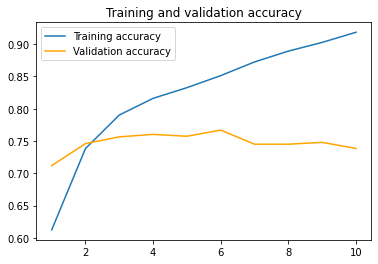

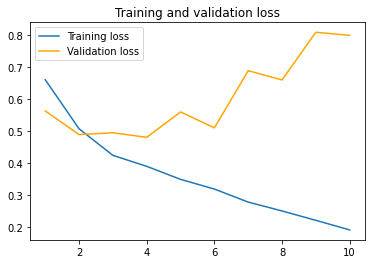

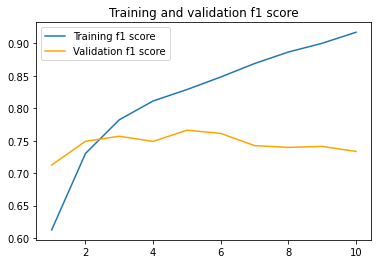

In [15]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

epochs = range(1, EPOCHS+1)

plt.plot(epochs, acc, linestyle='solid', label='Training accuracy')
plt.plot(epochs, val_acc, linestyle='solid', color='orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, linestyle='solid', label='Training loss')
plt.plot(epochs, val_loss, linestyle='solid', color='orange', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()
plt.plot(epochs, f1, linestyle='solid', label='Training f1 score')
plt.plot(epochs, val_f1, linestyle='solid', color='orange', label='Validation f1 score')
plt.title('Training and validation f1 score')
plt.legend()

plt.show()

In [ ]:
predicted_model = model.predict([test_html, test_data])

df_sub_model = pd.concat([test_id, pd.DataFrame(np.round(predicted_model), columns=['predicted']).astype(int)], axis=1)

df_sub_model.to_csv('submission_nn.csv', index=False, header=False)

In [21]:
# import optuna
from sklearn.model_selection import cross_val_score
from sklearn import svm
import lightgbm as lgb

train_data = np.concatenate([train_html, train_data], axis=1)
test_data = np.concatenate([test_html, test_data], axis=1)

print('train_data: {0}'.format(train_data.shape))
print('test_data: {0}'.format(test_data.shape))

# clf_svm = svm.SVC(kernel='rbf', C=1000, gamma=1e-3)
clf_lgb = lgb.LGBMClassifier(n_estimators = 10000, objective = 'binary', learning_rate = 0.001, num_leaves = 100, random_state = 2021, n_jobs = -1, importance_type = 'gain', colsample_bytree = 0.5, reg_lambda = 5)

# clf_svm.fit(train_data, Y_train)
clf_lgb.fit(train_data, Y_train)

train_data: (10545, 13554)
test_data: (10544, 13554)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='gain', learning_rate=0.001, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10000, n_jobs=-1, num_leaves=100,
               objective='binary', random_state=2021, reg_alpha=0.0,
               reg_lambda=5, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [26]:
predicted_lgb = clf_lgb.predict(test_data)
df_sub_lgb = pd.concat([df_submission['id'], pd.DataFrame(predicted_lgb, columns=['predicted']).astype(int)], axis=1)
df_sub_lgb.to_csv('submission_lgb.csv', index=False, header=False)

In [25]:
df_submission = pd.read_csv(PATH_SAMPLE_SUBMISSION, names=['id', 'pre'])
df_submission.head()

,id,pre
0,10545,0
1,10546,1
2,10547,0
3,10548,0
4,10549,0
